In [11]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from matplotlib import pyplot as plt


sys.path.insert(0, "..") 
from src.data import make_dataset
from src.features import build_features
from src.visualization import visualize

pd.set_option("display.precision", 5)
pd.set_option("display.max.columns", None)
pd.options.display.float_format = '{:6.5f}'.format

import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Bonds

In dit onderzoek is uitgegaan van een beperkte set bonds. Het is nog onduidelijk of de data van verlopen bonds ook zinvol is voor het onderzoek. Een bond is typisch maar kort in portefeuille waardoor we geen lange tijdreeksen hebben van een bepaalde bond. Mogelijk komt de bond wel erg over een met andere bonds die we in het verleden hebben gehad en zegt het koerstverloop van die bonds iets over het koersverloop van de huidige bonds. Mogelijk spelen benchmark bonds hier een rol bij. 

In [12]:
df_bonds = make_dataset.read_pkl('bonds')

2022-01-10 21:10:44.883 | INFO     | src.data.make_dataset:read_pkl:373 - Load preprocessed bonds data


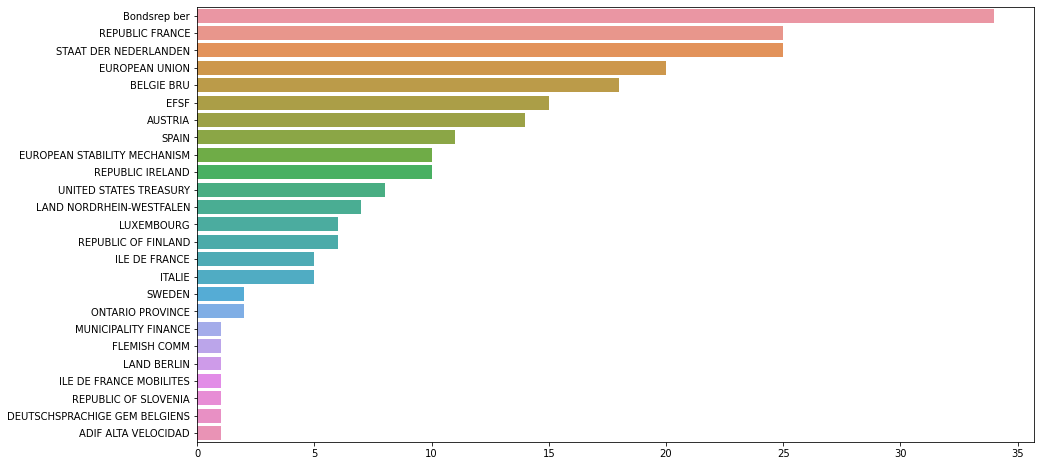

In [15]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'issuer_name')

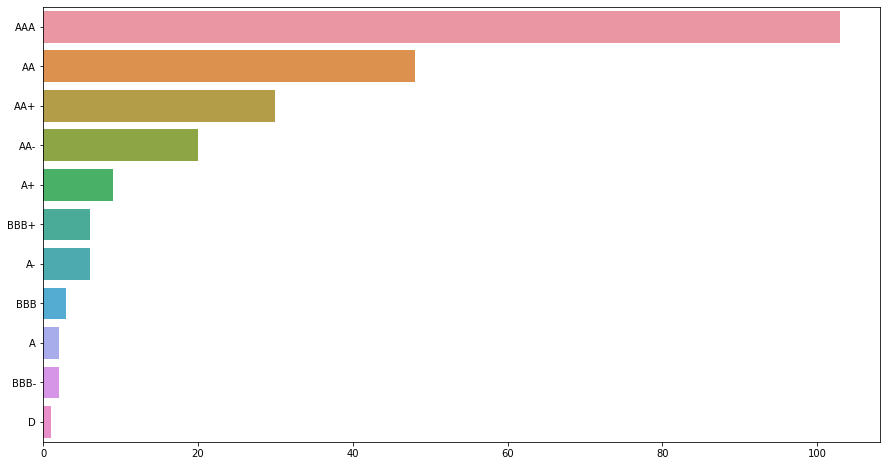

In [16]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'issue_rating')

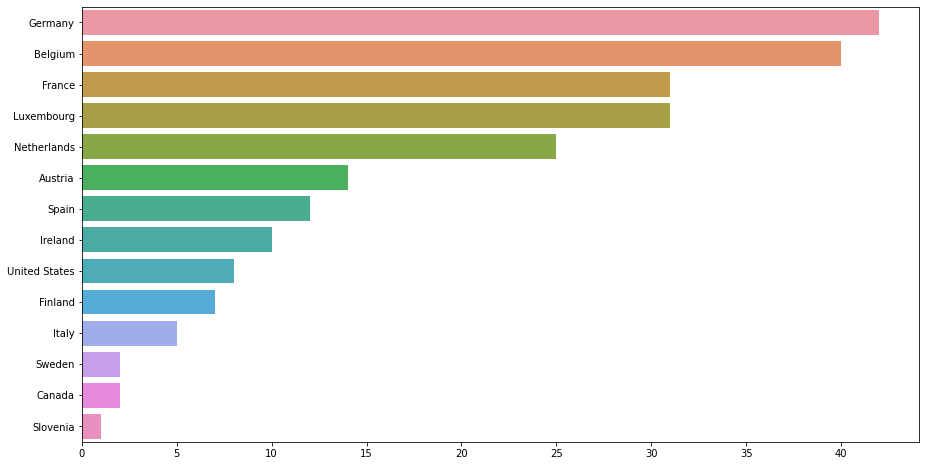

In [17]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'country')

Bond prices

In [19]:
df_price = make_dataset.read_pkl('price')
df_price.head()

2022-01-10 21:27:58.506 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed price data


,reference_identifier,ccy,rate_dt,mid
0,DE0001135143,EUR,2010-12-17,136.76000
1,NL0000102275,EUR,2010-12-17,103.39000
2,DE0001135424,EUR,2010-12-17,95.45300
3,NL0009446418,EUR,2010-12-17,102.69000
4,NL0000102234,EUR,2010-12-17,106.22000


In [20]:
df_price.groupby('reference_identifier').count()


,ccy,rate_dt,mid
reference_identifier,,,
AT0000A001X2,2737,2737,2737
AT0000A0U3T4,2542,2542,2542
AT0000A105W3,2230,2230,2230
AT0000A185T1,1925,1925,1925
AT0000A19XC3,1284,1284,1284
...,...,...,...
XS1062909384,1275,1275,1275
XS1692485912,116,116,116
XS1756338551,1017,1017,1017


2022-01-10 21:28:05.739 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed bp data
2022-01-10 21:28:05.844 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed yield data


<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

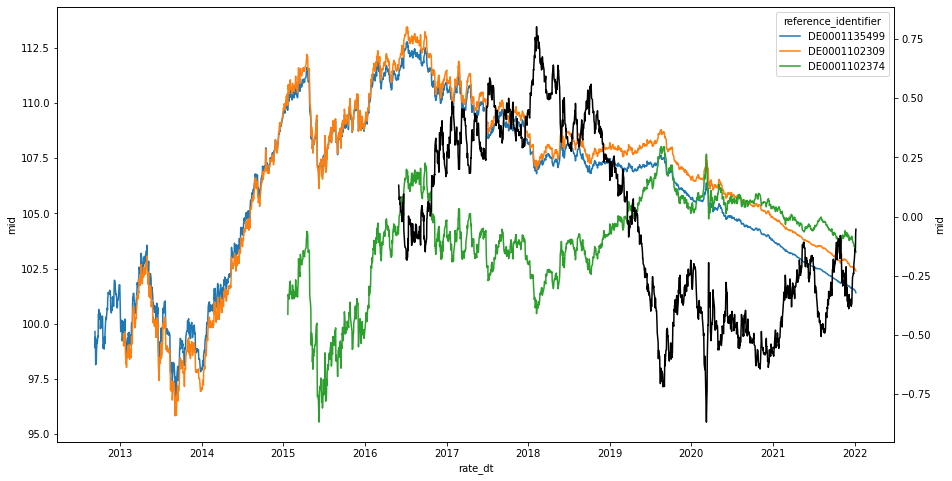

In [21]:
#df = make_dataset.join_bond_data(df_bonds,df_price,['DE0001102309','DE0001102374', 'DE0001135499']) # Example 3 German Bonds 10 Years
plt.figure(figsize=(15,8))

df_bp = make_dataset.read_pkl('bp')

df_yield = make_dataset.read_pkl('yield')
df_y10 = df_yield[df_yield['timeband']=='10 YEARS']
df_y10_germany = df_y10[df_y10['country']=='Germany']


df = df_bp[df_bp['isin'].isin(['DE0001102309','DE0001102374', 'DE0001135499'])]
df = df[df['rate_dt'] >= df_y10_germany['rate_dt'].min()]
sns.lineplot(data = df, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

df_y10_germany = df_y10_germany[df_y10_germany['rate_dt'] >= df['rate_dt'].min()]

ax2 = plt.twinx()
sns.lineplot(data = df_y10_germany, x = 'rate_dt', y = 'mid', color = 'black', ax=ax2)


Wanneer we kijken naar bonds met een zelfde looptijd, en zelfde issuer, dan zien we dat de term spread langzaam afneemt. Ook zien we dat hier waarschijnlijk een fout zit in de invoer

<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

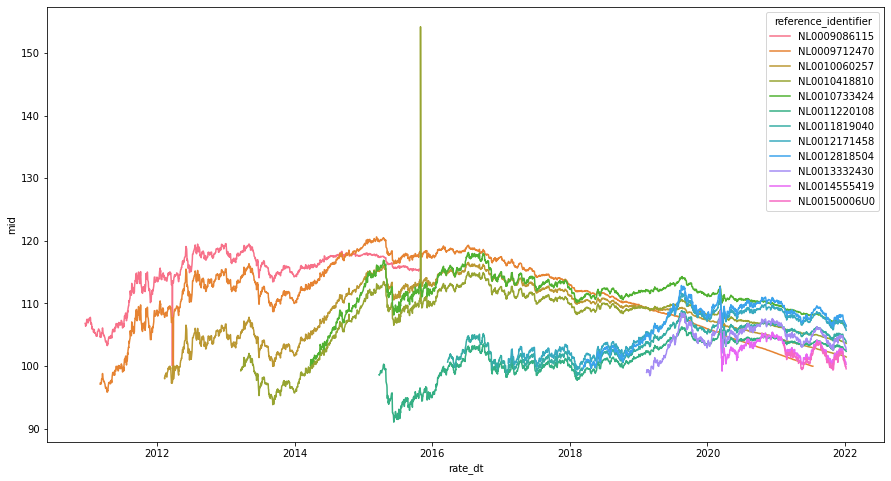

In [22]:
# 10 years bonds from one issuer
df_10y = df_bp[df_bp['bond_duration'].dt.days.between(3500,4000)]
df = df_10y.query('issuer_name == "STAAT DER NEDERLANDEN"').sort_values('first_coupon_date')
plt.figure(figsize=(15,8))
sns.lineplot(data = df, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

Wanneer we kijken naar bonds met een zelfde looptijd, van verschillende issuers dan zien we het verloop van de credit spread tussen de landen.

<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

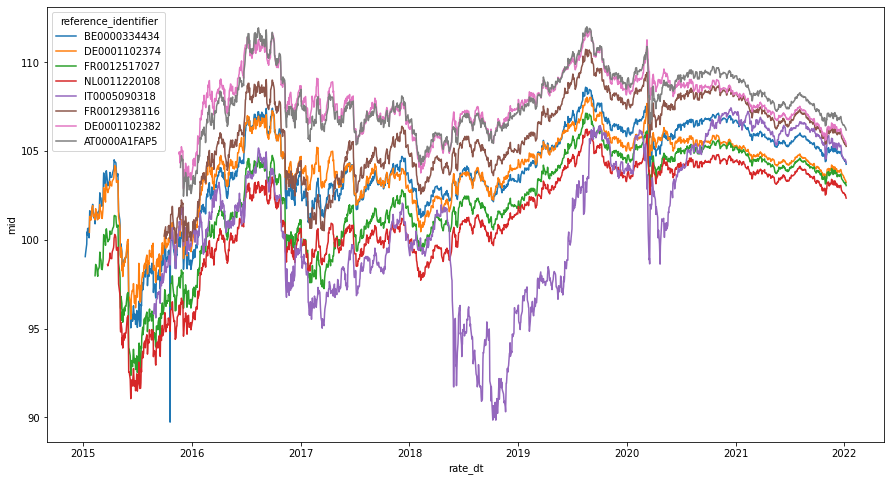

In [24]:
# 10 years bonds from one year

df_10y = df_bp[df_bp['bond_duration'].dt.days.between(3500,4000)]
df  = df_10y[df_10y['issue_dt'].between('1-jan-2015', '31-dec-2015')]
plt.figure(figsize=(15,8))
sns.lineplot(data = df, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

<AxesSubplot:xlabel='days', ylabel='mid'>

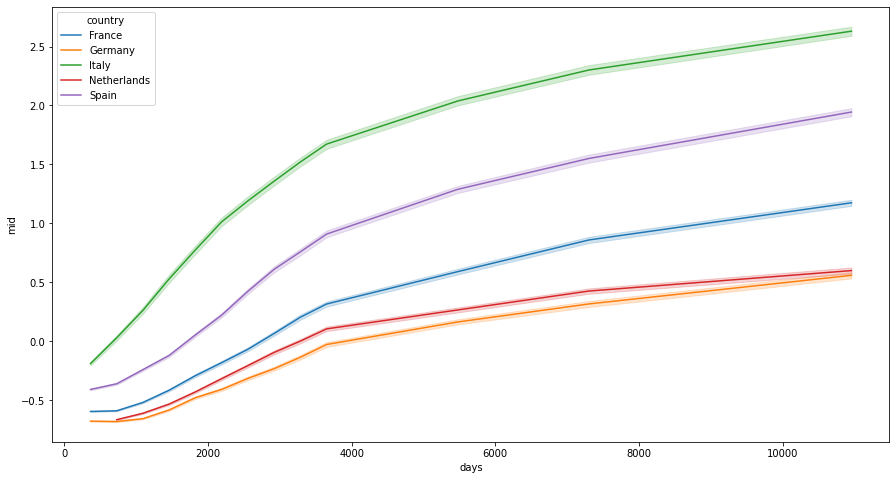

In [25]:
plt.figure(figsize=(15,8))
df_yield['days'] = df_yield['time'].dt.days
sns.lineplot(data = df_yield, x = 'days', y ='mid', hue = 'country')

In [26]:
df_bonds_i = df_bonds[( df_bonds['country'] == 'Italy' ) & (df_bonds['issue_dt'] <= '1-jan-2018')  & (df_bonds['mature_dt'] >= '1-jan-2022')]
df_bonds_i

,ccy,country,issue_dt,first_coupon_date,mature_dt,isin,issuer_name,coupon_frq,coupon,tot_issue,cfi_code,issue_rating,bond_duration
24,EUR,Italy,2015-03-02,2015-06-01,2025-06-01,IT0005090318,ITALIE,SEMI ANNUAL,1.50000,19786.72000,DBFUFB,BBB-,3744 days
84,EUR,Italy,2016-03-01,2016-06-01,2026-06-01,IT0005170839,ITALIE,SEMI ANNUAL,1.60000,16249.50000,DBFUFB,BBB-,3744 days


In [31]:
df_y10_italy

,country,rate_dt,timeband,ratename,ccy,actual_dt,datedays,bid,offer,int_basis,time,mid
48867,Italy,1990-01-01,10 YEARS,GOV Yield Curve IT BB,EUR,2000-01-01,3654,0.00000,0.00000,ANNUAL,3652 days,0.00000
48884,Italy,2016-06-01,10 YEARS,GOV Yield Curve IT BB,EUR,2026-06-01,3654,1.38840,1.39100,ANNUAL,3652 days,1.38970
48901,Italy,2016-06-02,10 YEARS,GOV Yield Curve IT BB,EUR,2026-06-02,3658,1.38750,1.38000,ANNUAL,3652 days,1.38375
48918,Italy,2016-06-03,10 YEARS,GOV Yield Curve IT BB,EUR,2026-06-03,3657,1.32820,1.33500,ANNUAL,3652 days,1.33160
48935,Italy,2016-06-06,10 YEARS,GOV Yield Curve IT BB,EUR,2026-06-06,3654,1.39900,1.39500,ANNUAL,3652 days,1.39700
...,...,...,...,...,...,...,...,...,...,...,...,...
73198,Italy,2022-01-03,10 YEARS,GOV Yield Curve IT BB,EUR,2032-01-03,3654,1.19600,1.18700,ANNUAL,3652 days,1.19150
73215,Italy,2022-01-04,10 YEARS,GOV Yield Curve IT BB,EUR,2032-01-04,3654,1.19200,1.18400,ANNUAL,3652 days,1.18800
73232,Italy,2022-01-05,10 YEARS,GOV Yield Curve IT BB,EUR,2032-01-05,3654,1.24500,1.23700,ANNUAL,3652 days,1.24100
73249,Italy,2022-01-06,10 YEARS,GOV Yield Curve IT BB,EUR,2032-01-06,3658,1.27400,1.26600,ANNUAL,3652 days,1.27000


<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

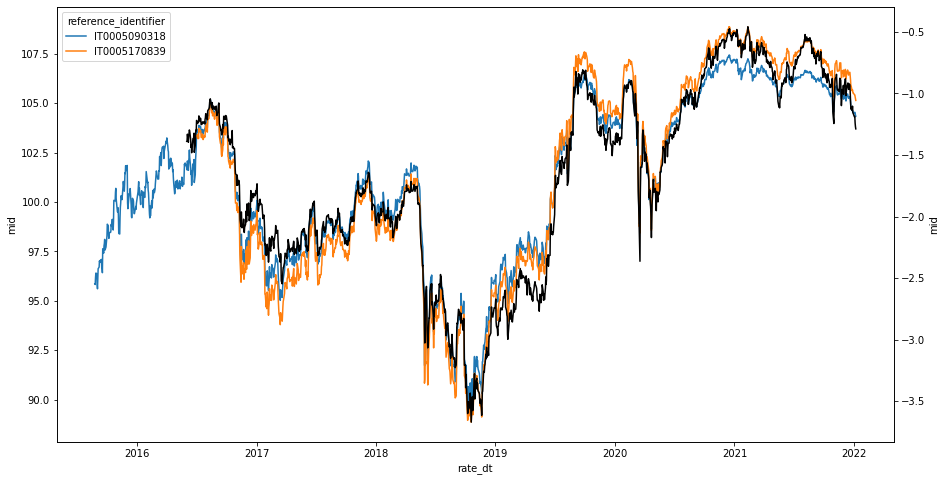

In [33]:
isins = df_bonds_i['isin'].to_list()
df_bp_i = df_bp[df_bp['isin'].isin(isins)]
plt.figure(figsize=(15,8))
sns.lineplot(data = df_bp_i, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

df_y10_italy = df_y10[df_y10['country']=='Italy']
df_y10_italy = df_y10_italy[df_y10_italy['rate_dt'] >= df_bp_i['rate_dt'].min()]
df_y10_italy['mid'] = df_y10_italy['mid'] * -1
ax2 = plt.twinx()
sns.lineplot(data = df_y10_italy, x = 'rate_dt', y = 'mid', color = 'black', ax=ax2)

Government Yield

In [34]:
df_yield = make_dataset.read_pkl('yield')

2022-01-10 21:40:07.846 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed yield data


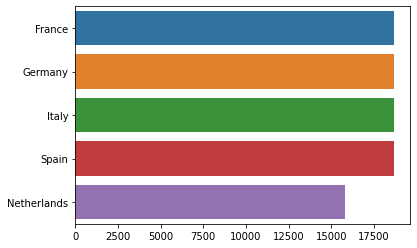

In [35]:
visualize.countplot(data = df_yield, x = 'country')

Credit Spread

Term Spread

Inflation

In [36]:
df_inflation = make_dataset.read_pkl('inflation')

2022-01-10 21:40:32.006 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed inflation data


Inflation should be negatively correlated to the bond price